In [1]:
import os
import pandas as pd
import numpy as np
from quantities import ns, s
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def load_data(recording, data_dir, verbose):
    if verbose:
        print('Loading data:\t{}'.format(recording))
    path = ''.join([os.path.join(data_dir, recording, recording), '.csv'])
    return pd.read_csv(path)


def manipulate_df(df):
    df['spike'] = 1
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    return df


def create_time_series(df):
    df = df.pivot_table(index='time',
                        columns='spike_cluster',
                        values='spike',
                        aggfunc='count')
    return df


def get_condition_times(df, experiment):
    if experiment == 'DREADD':
        max_time = df[df['condition'] == 'CNO']['time'].iloc[-1].total_seconds()
        max_time = list(zip(['CNO'], [max_time]))
        n_conditions = 1
    elif experiment == 'CIT':
        max_time_cit = df[df['condition'] == 'CIT']['time'].iloc[-1].total_seconds()
        if 'WAY' in df['condition'].values:
            max_time_way = df[df['condition'] == 'WAY']['time'].iloc[-1].total_seconds()
            n_conditions = 2
        else:
            max_time_way = max_time_cit
            n_conditions = 1
        max_time = list(zip(['CIT', 'WAY'], [max_time_cit, max_time_way]))
    return max_time, n_conditions


def calculate_neuron_cov(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    cv_isis = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            cv_isi = cv(isi(spike_train))
        except IndexError:
            cv_isi = np.nan
        cv_isis[ind] = cv_isi

    return cv_isis


def calculate_neuron_mfr(col, num_mins_per_bin, total_time):
    num_bins = np.int(total_time / num_mins_per_bin)
    col_bins = np.array_split(col, num_bins)
    mfrs = pd.Series(np.zeros(num_bins))

    for ind, col_bin in enumerate(col_bins):
        spike_times = pd.to_numeric(col_bin[col_bin.notnull()].index.values)
        try:
            spike_train = SpikeTrain(times=spike_times,
                                     t_stop=spike_times[-1],
                                     units=ns)
            mfr = mean_firing_rate(spike_train)
        except IndexError:
            mfr = np.nan
        mfrs[ind] = mfr
    mfrs *= 10**10
    return mfrs

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\ProgramData\Anaconda3\lib\site-packages\elephant\spade.py:82: UserWarning: fim.so not found in elephant/spade_src folder,you are using the python implementation of fast fca
  'you are using the python implementation of fast fca')


In [2]:
df = load_data(recording='2018-04-12_371b',
                       data_dir=r'F:\SERT_DREAD\Combined_binary_files_probe\spikes_time_series',
                       verbose=True)
df = manipulate_df(df)

Loading data:	2018-04-12_371b


In [3]:
max_times, n_conditions = get_condition_times(df, experiment='DREADD')
if n_conditions == 1:
    max_time = max_times[0][1]
elif n_conditions == 2:
    max_time = max_times[1][1]

In [4]:
df_base = df[df['condition'] == 'Baseline']
df_ts = create_time_series(df_base)
mean_firing_rates_ts = df_ts.apply(func=calculate_neuron_mfr,
                                           num_mins_per_bin=2,
                                           total_time=60)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:998: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
df_cit_base = df[df['condition'] == 'CNO']
df_cit_ts = create_time_series(df_cit_base)
cit_mean_firing_rates_ts = df_cit_ts.apply(func=calculate_neuron_mfr,
                                           num_mins_per_bin=2,
                                           total_time=60)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:998: RuntimeWarning: Mean of empty slice.
  return a.std(axis) / a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
mean_firing_rates_ts.fillna(value=0, inplace=True)

In [7]:
cit_mean_firing_rates_ts.fillna(value=0, inplace=True)

In [25]:
mean_firing_rates_ts.head()

spike_cluster,0,2,11,12,16,22,25,26,29,32,...,131,132,133,134,136,141,142,143,144,145
0,5.204741,19.940715,0.128022,10.037542,30.617008,5.656295,0.053554,8.612287,1.008285,0.580460,...,0.000000,0.079413,5.996239,0.000000,0.000000,32.266896,78.706151,26.992280,9.522319,308.113711
1,2.424753,10.465233,0.238302,0.321858,15.658706,0.214523,0.107033,6.193538,0.843091,0.041643,...,0.000000,0.079329,5.453593,0.000000,0.000000,16.974808,24.534482,20.110302,6.957626,151.171009
2,9.418246,4.456438,7.701622,1.549148,11.503369,2.107401,0.254095,5.067203,1.975030,1.037399,...,6.764858,6.230473,18.472544,5.004996,2.808316,8.522241,11.520714,10.641928,4.699056,88.883755
3,9.301492,6.517363,9.191412,2.116660,7.781345,3.097082,0.841183,4.775290,2.783231,1.166284,...,7.013529,6.981492,16.979359,5.970977,3.375129,5.878126,9.422844,7.152714,4.005094,61.679706
4,8.176061,5.487200,7.580256,2.405477,2.196866,3.498949,1.484011,6.993995,4.798324,1.976137,...,4.419632,5.121380,8.410061,4.796530,1.704869,3.743943,6.201470,6.864098,1.573973,54.333135


In [24]:
cit_mean_firing_rates_ts.head()

spike_cluster,0,2,11,12,16,22,25,26,29,32,...,131,132,133,134,136,141,142,143,144,145
0,1.848409,1.674350,1.275105,0.803650,0.691145,1.585970,0.980454,0.926905,0.900083,1.384998,...,1.194739,1.229624,1.122442,1.133111,0.442016,1.044741,0.782234,1.427844,0.061612,0.747507
1,1.988014,1.491047,1.700716,0.768816,0.732624,1.281316,0.727466,0.768879,0.773969,1.400475,...,1.245109,1.268433,1.402972,1.149315,0.489236,1.162254,0.944855,1.364196,0.046680,0.572075
2,1.858522,1.421384,1.596255,0.901805,0.631990,1.079321,0.717077,0.724418,0.647030,1.241495,...,1.166620,1.209030,0.517197,1.161552,0.597074,1.064150,0.744493,1.511266,0.060281,0.609556
3,1.909784,1.093757,1.958092,0.927160,0.649485,0.968219,0.625379,0.794491,0.408050,1.226509,...,1.180647,1.168556,0.231781,1.156488,0.649487,1.122745,0.755714,1.424489,0.029044,0.386411
4,1.759317,0.612344,1.881256,1.055582,0.788152,0.516050,0.652209,0.736559,0.652260,1.355817,...,1.168150,1.081364,1.374621,1.010981,0.684938,1.090733,0.879633,1.243205,0.051643,0.124410


## Check for assumptions before conducting t-test

### Assumption: There's no sigificant outlier within the group

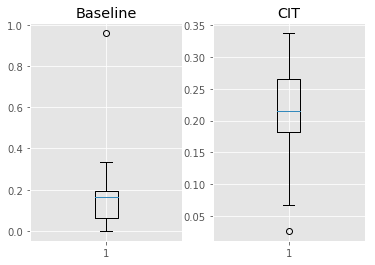

In [30]:
cluster = 45

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].boxplot(mean_firing_rates_ts.loc[:,cluster])
ax[0].title.set_text('Baseline')
ax[1].boxplot(cit_mean_firing_rates_ts.loc[:,cluster])
ax[1].title.set_text('CIT')
plt.show()

##### Check for outliers. Outliers are defined as data points outside standard deviation

In [31]:
def outliers(tmp):
    """tmp is a list of numbers"""
    outs = []
    mean = sum(tmp)/(1.0*len(tmp))
    var = sum((tmp[i] - mean)**2 for i in range(0, len(tmp)))/(1.0*len(tmp))
    std = var**0.5
    outs = [tmp[i] for i in range(0, len(tmp)) if abs(tmp[i]-mean) > 1.96*std]
    return outs


print(outliers(cit_mean_firing_rates_ts.loc[:,cluster]))

[0.0665576519060105, 0.02611363275892915]


### Assumption: The distribution of the two groups should follow the normal distribution

#### Method 1: Just eyeball it using histogram

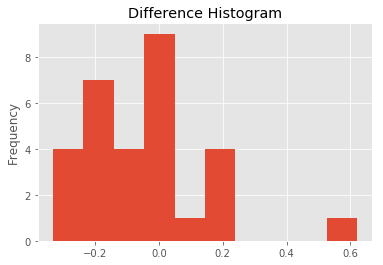

In [32]:
difference_before_after = mean_firing_rates_ts.loc[:,cluster] - cit_mean_firing_rates_ts.loc[:,cluster]
difference_before_after.plot(kind='hist', title= 'Difference Histogram')

#### Method 2 (A lil bit more sophisticated): Using Q-Q plot. 

##### Data points far off of the red line indicate deviations from normality.

Text(0.5,1,'Baseline mfr Q-Q Plot')

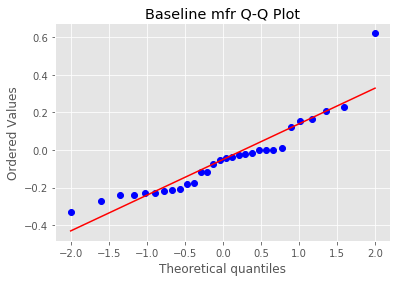

In [33]:
stats.probplot(difference_before_after, dist="norm", plot= plt)
plt.title("Baseline mfr Q-Q Plot")

### Method 3 (looking for the holy p value): Shapiro-Wilk test for normality 

##### The second value of the output is the p value. p value < 0.05 indicates violation of the assumption

In [34]:
stats.shapiro(difference_before_after)

(0.8874437808990479, 0.0041983118280768394)

## The data set (amazingly) failed every single assumption щ(゜ロ゜щ). 

### Let's use non-parametric test instead

##### p value < 0.05 is statistically significant. If significant, reject H0

##### Null hypothesis is: "Citalopram did not cause any change in the firing rate"

In [35]:
stats.mannwhitneyu(mean_firing_rates_ts.loc[:,134], cit_mean_firing_rates_ts.loc[:,134])

MannwhitneyuResult(statistic=60.0, pvalue=4.240376605923607e-09)

In [44]:
mean_firing_rates_ts.loc[:,88].mean()

0.9127787257732908

In [45]:
cit_mean_firing_rates_ts.loc[:,88].mean()

0.37651713929257546

In [41]:
pd.DataFrame({'Before':mean_firing_rates_ts.loc[:,45], 'After':cit_mean_firing_rates_ts.loc[:,45]})

,After,Before
0,0.337543,0.958519
1,0.290028,0.062540
2,0.332246,0.000000
3,0.270441,0.031162
4,0.265178,0.026432
5,0.305265,0.034222
6,0.274103,0.061195
7,0.246646,0.036244
8,0.332399,0.116515
9,0.266430,0.039457


### Good! Now, put it in a loop

In [19]:
def outliers(tmp):
    """tmp is a list of numbers"""
    outs = []
    mean = sum(tmp)/(1.0*len(tmp))
    var = sum((tmp[i] - mean)**2 for i in range(0, len(tmp)))/(1.0*len(tmp))
    std = var**0.5
    outs = [tmp[i] for i in range(0, len(tmp)) if abs(tmp[i]-mean) > 1.96*std]
    return outs

def check_assumption(cit_mean_firing_rates_ts, mean_firing_rates_ts, cluster):
    outlier_list_cit = outliers(cit_mean_firing_rates_ts.loc[:,cluster])
    outlier_list_base = outliers(mean_firing_rates_ts.loc[:,cluster])
    difference_before_after = mean_firing_rates_ts.loc[:,cluster] - cit_mean_firing_rates_ts.loc[:,cluster]
    normality_p_value = stats.shapiro(difference_before_after)
    if (outlier_list_cit) or (outlier_list_base) or (normality_p_value[1]<0.05):
        assumption = 'False'
    else:
        assumption = 'True'
    return assumption

def check_if_significant(df):
    if df['p value'] < 0.05:
        df['effect'] = 'reacted'
    else:
        df['effect'] = 'not reacted'
    return df

In [20]:
len(cit_mean_firing_rates_ts.columns)**(.5)

6.082762530298219

In [22]:
p_value_list = []
z_value_list = []
for cluster in cit_mean_firing_rates_ts.columns:
    assumption = check_assumption(cit_mean_firing_rates_ts = cit_mean_firing_rates_ts, mean_firing_rates_ts = mean_firing_rates_ts, cluster = cluster)
    if assumption == 'False':
        p_value = stats.mannwhitneyu(mean_firing_rates_ts.loc[:,cluster], cit_mean_firing_rates_ts.loc[:,cluster])[1]
        z_value = stats.mannwhitneyu(mean_firing_rates_ts.loc[:,cluster], cit_mean_firing_rates_ts.loc[:,cluster])[0]/(len(cit_mean_firing_rates_ts.columns)**(.5))
    if assumption == 'True':
        p_value = stats.ttest_rel(mean_firing_rates_ts.loc[:,cluster], cit_mean_firing_rates_ts.loc[:,cluster])
    p_value_list.append(p_value)
    z_value_list.append(z_value)
df_category = pd.DataFrame({'p value': p_value_list, 'spike_cluster':cit_mean_firing_rates_ts.columns, 'effect size': z_value_list})
df_category = df_category.apply(check_if_significant, axis = 1)
df_category.set_index('spike_cluster')

,effect size,p value,effect
spike_cluster,,,
0.0,0.000000,1.509930e-11,reacted
2.0,16.768697,1.391437e-07,reacted
11.0,10.850333,7.147083e-09,reacted
12.0,3.123581,9.783900e-11,reacted
16.0,1.972788,4.959314e-11,reacted
22.0,0.986394,2.747026e-11,reacted
25.0,6.740358,7.732606e-10,reacted
26.0,0.000000,1.509930e-11,reacted
29.0,0.164399,1.669194e-11,reacted
